# Time Series Animation: Watching a Year of Vegetation Change

So far we've compared two snapshots (summer vs winter). But satellites capture images **continuously** — Sentinel-2 revisits the same location every 5 days.

In this notebook we'll:
1. Load one image per month for an entire year
2. Compute NDVI for each month
3. Create an animated GIF showing vegetation change over time
4. Plot the NDVI trend as a time series graph

**What you'll see:** The seasonal "pulse" of vegetation — growth in spring, peak in summer, senescence in fall, dormancy in winter.

---
## 1. Setup

In [1]:
from pystac_client import Client
import planetary_computer as pc
from odc.stac import stac_load

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Connect to Planetary Computer
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
print("Connected to Planetary Computer")

/Users/hds-altec009/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Connected to Planetary Computer


---
## 2. Configuration

Define the location and time range for our analysis.

In [2]:
# Same location as previous notebooks
bbox = [-105.00046265789766, 40.61040537905372, -104.97822774714184, 40.62419090978705]

# Full year of 2024
year = 2024
months = list(range(1, 13))  # January through December

print(f"Location: {bbox[1]:.4f}°N, {bbox[0]:.4f}°W")
print(f"Time range: {year}-01 to {year}-12")

Location: 40.6104°N, -105.0005°W
Time range: 2024-01 to 2024-12


---
## 3. Helper Functions

In [3]:
def normalize(img, pmin=2, pmax=98):
    """Normalize image to 0-1 range using percentiles."""
    lo, hi = np.nanpercentile(img, [pmin, pmax])
    return np.clip((img - lo) / (hi - lo + 1e-6), 0, 1)

def compute_ndvi(nir, red):
    """Compute NDVI from NIR and Red bands."""
    return (nir - red) / (nir + red + 1e-6)

def get_month_date_range(year, month):
    """Get date range string for a given month."""
    if month == 12:
        return f"{year}-{month:02d}-01/{year}-{month:02d}-31"
    else:
        # Get last day of month
        import calendar
        last_day = calendar.monthrange(year, month)[1]
        return f"{year}-{month:02d}-01/{year}-{month:02d}-{last_day:02d}"

def load_monthly_image(catalog, bbox, year, month, max_cloud_cover=30):
    """
    Load the best available image for a given month.
    Returns None if no suitable image is found.
    """
    date_range = get_month_date_range(year, month)
    
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=bbox,
        datetime=date_range,
        query={"eo:cloud_cover": {"lt": max_cloud_cover}},
    )
    
    items = list(search.items())
    
    if len(items) == 0:
        return None, None
    
    # Select image with lowest cloud cover
    items_sorted = sorted(items, key=lambda x: x.properties.get('eo:cloud_cover', 100))
    item = items_sorted[0]
    
    # Sign and load
    signed_item = pc.sign(item)
    data = stac_load(
        [signed_item],
        bands=["B02", "B03", "B04", "B08"],
        bbox=bbox,
        crs="EPSG:4326",
        resolution=0.0001,
        groupby="solar_day",
    )
    
    metadata = {
        'date': item.datetime,
        'cloud_cover': item.properties.get('eo:cloud_cover', 0),
        'month': month,
        'month_name': datetime(year, month, 1).strftime('%B')
    }
    
    return data, metadata

print("Helper functions defined.")

Helper functions defined.


---
## 4. Load Monthly Images

This will take a minute or two as we download 12 months of data. We'll show progress as we go.

In [4]:
monthly_data = []

print("Loading monthly images...")
print("-" * 50)

for month in months:
    month_name = datetime(year, month, 1).strftime('%B')
    print(f"  {month_name:12s} ... ", end="")
    
    data, meta = load_monthly_image(catalog, bbox, year, month)
    
    if data is not None:
        # Compute RGB and NDVI
        rgb = normalize(np.stack([
            data["B04"].isel(time=0).values,
            data["B03"].isel(time=0).values,
            data["B02"].isel(time=0).values,
        ], axis=-1))
        
        ndvi = compute_ndvi(
            data["B08"].isel(time=0).values.astype("float32"),
            data["B04"].isel(time=0).values.astype("float32")
        )
        
        monthly_data.append({
            'month': month,
            'month_name': meta['month_name'],
            'date': meta['date'],
            'cloud_cover': meta['cloud_cover'],
            'rgb': rgb,
            'ndvi': ndvi,
            'mean_ndvi': np.nanmean(ndvi)
        })
        print(f"OK ({meta['date'].strftime('%Y-%m-%d')}, {meta['cloud_cover']:.1f}% clouds, NDVI: {np.nanmean(ndvi):.2f})")
    else:
        print("NO DATA (too cloudy)")

print("-" * 50)
print(f"Successfully loaded {len(monthly_data)} of 12 months")

Loading monthly images...
--------------------------------------------------
  January      ... OK (2024-01-31, 0.0% clouds, NDVI: 0.11)
  February     ... OK (2024-02-05, 0.0% clouds, NDVI: 0.11)
  March        ... OK (2024-03-18, 0.0% clouds, NDVI: 0.11)
  April        ... OK (2024-04-25, 0.0% clouds, NDVI: 0.17)
  May          ... OK (2024-05-30, 0.0% clouds, NDVI: 0.21)
  June         ... OK (2024-06-06, 0.0% clouds, NDVI: 0.19)
  July         ... OK (2024-07-31, 0.0% clouds, NDVI: 0.21)
  August       ... OK (2024-08-28, 0.0% clouds, NDVI: 0.28)
  September    ... OK (2024-09-07, 0.0% clouds, NDVI: 0.26)
  October      ... OK (2024-10-02, 0.0% clouds, NDVI: 0.22)
  November     ... OK (2024-11-11, 0.0% clouds, NDVI: 0.17)
  December     ... OK (2024-12-06, 0.0% clouds, NDVI: 0.15)
--------------------------------------------------
Successfully loaded 12 of 12 months


---
## 5. NDVI Time Series Plot

Before the animation, let's visualize the seasonal trend as a simple line graph.

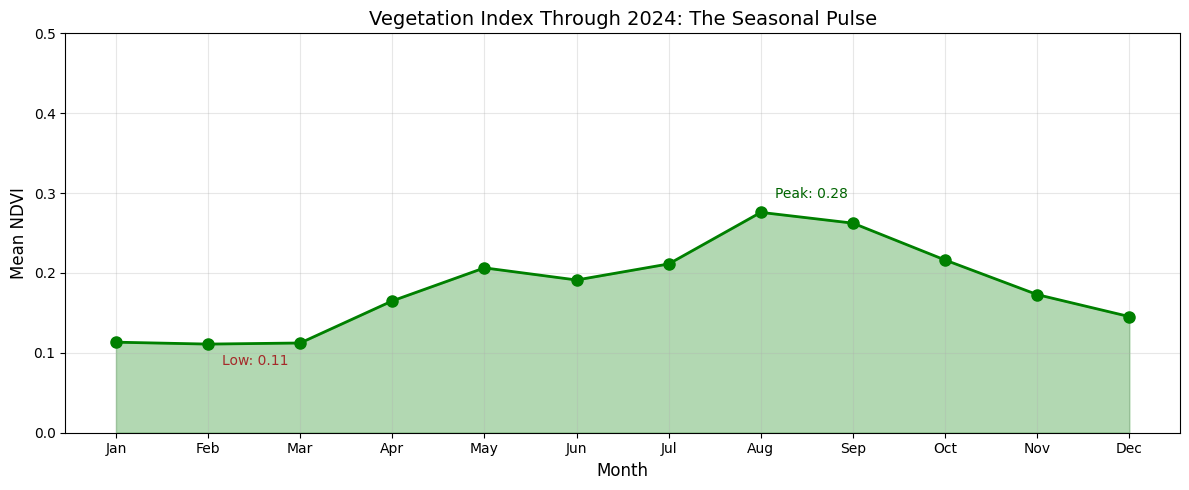

In [5]:
# Extract data for plotting
months_loaded = [d['month'] for d in monthly_data]
month_names = [d['month_name'][:3] for d in monthly_data]  # Abbreviated names
mean_ndvi_values = [d['mean_ndvi'] for d in monthly_data]
dates = [d['date'] for d in monthly_data]

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(months_loaded, mean_ndvi_values, 'o-', linewidth=2, markersize=8, color='green')
ax.fill_between(months_loaded, mean_ndvi_values, alpha=0.3, color='green')

ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Mean NDVI", fontsize=12)
ax.set_title(f"Vegetation Index Through {year}: The Seasonal Pulse", fontsize=14)

ax.set_xticks(months_loaded)
ax.set_xticklabels(month_names)
ax.set_ylim(0, 0.5)
ax.grid(True, alpha=0.3)

# Add annotations for min/max
max_idx = np.argmax(mean_ndvi_values)
min_idx = np.argmin(mean_ndvi_values)

ax.annotate(f'Peak: {mean_ndvi_values[max_idx]:.2f}', 
            xy=(months_loaded[max_idx], mean_ndvi_values[max_idx]),
            xytext=(10, 10), textcoords='offset points',
            fontsize=10, color='darkgreen')

ax.annotate(f'Low: {mean_ndvi_values[min_idx]:.2f}', 
            xy=(months_loaded[min_idx], mean_ndvi_values[min_idx]),
            xytext=(10, -15), textcoords='offset points',
            fontsize=10, color='brown')

plt.tight_layout()
plt.show()

### Interpreting the Time Series

You should see a clear seasonal pattern:
- **Winter (Jan-Feb):** Low NDVI — dormant vegetation, possibly snow
- **Spring (Mar-May):** Rising NDVI — green-up begins
- **Summer (Jun-Aug):** Peak NDVI — maximum photosynthetic activity
- **Fall (Sep-Nov):** Declining NDVI — senescence, harvest
- **Winter (Dec):** Back to low NDVI

---
## 6. Monthly Image Grid

View all months at once to see the progression.

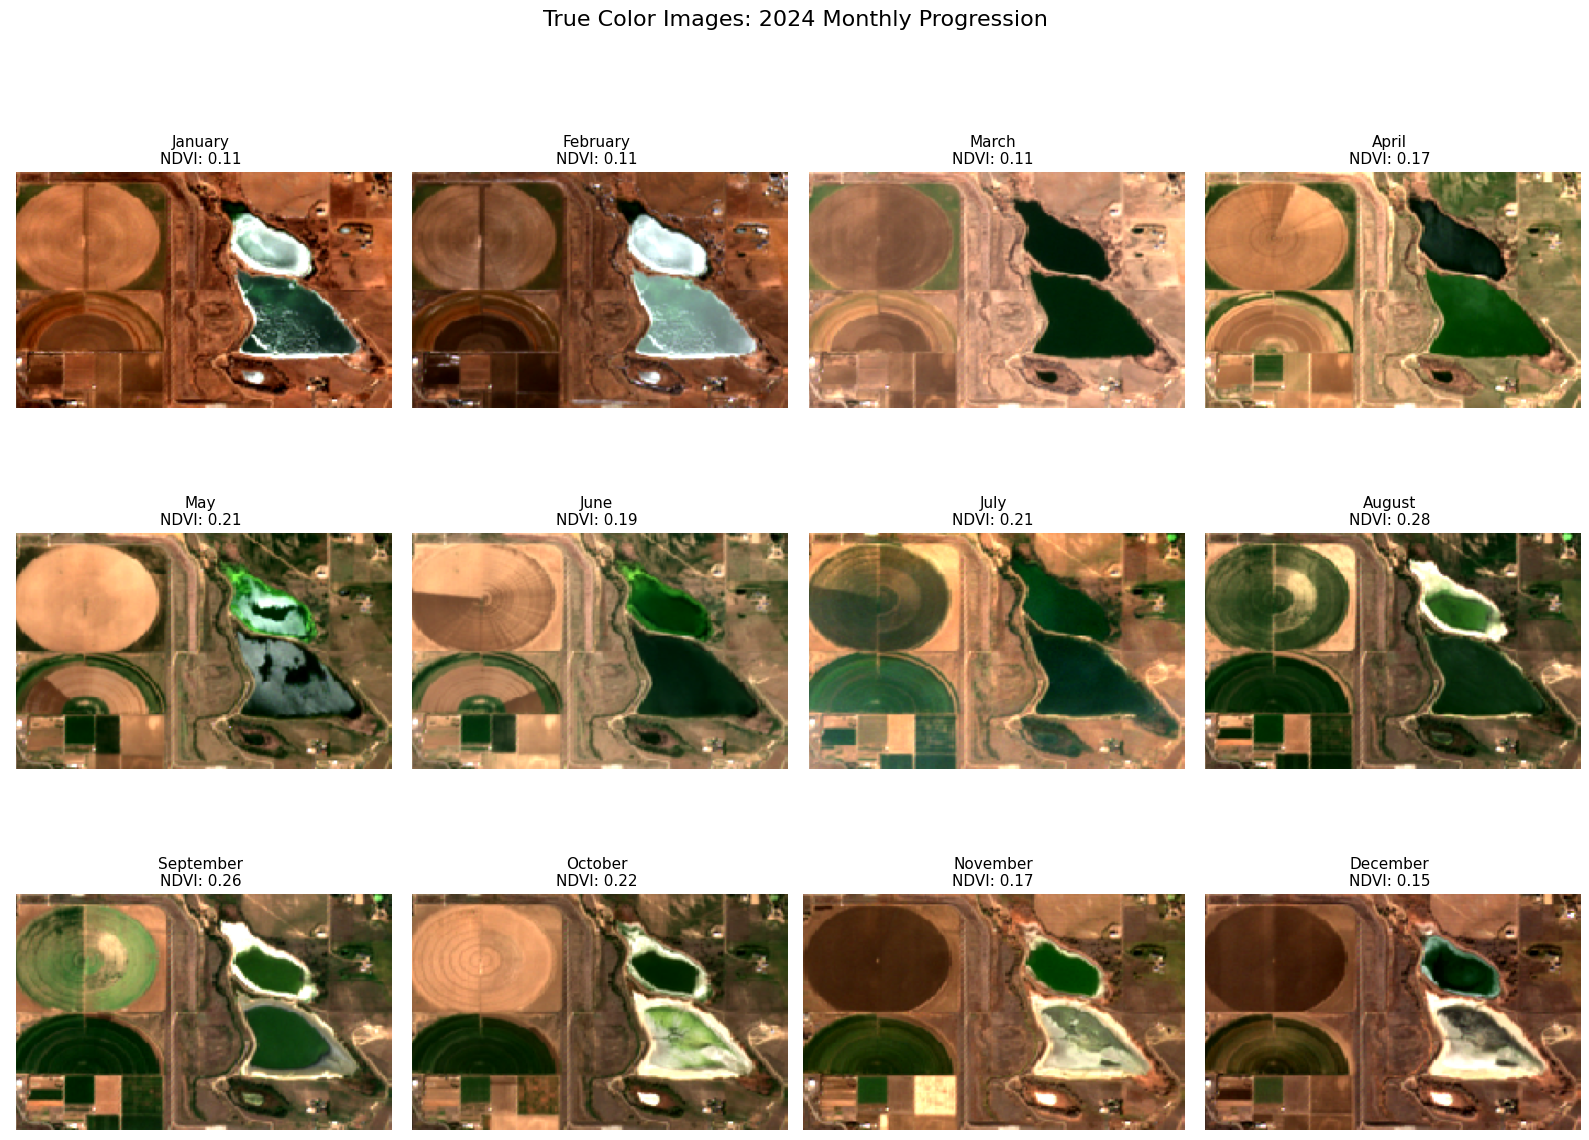

In [7]:
n_months = len(monthly_data)
cols = 4
rows = (n_months + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
axes = axes.flatten()

for idx, month_info in enumerate(monthly_data):
    axes[idx].imshow(month_info['rgb'])
    axes[idx].set_title(f"{month_info['month_name']}\nNDVI: {month_info['mean_ndvi']:.2f}", fontsize=11)
    axes[idx].axis('off')

# Hide unused subplots
for idx in range(n_months, len(axes)):
    axes[idx].axis('off')

plt.suptitle(f"True Color Images: {year} Monthly Progression", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

---
## 7. NDVI Monthly Grid

Same grid but showing NDVI — the seasonal change is more dramatic here.

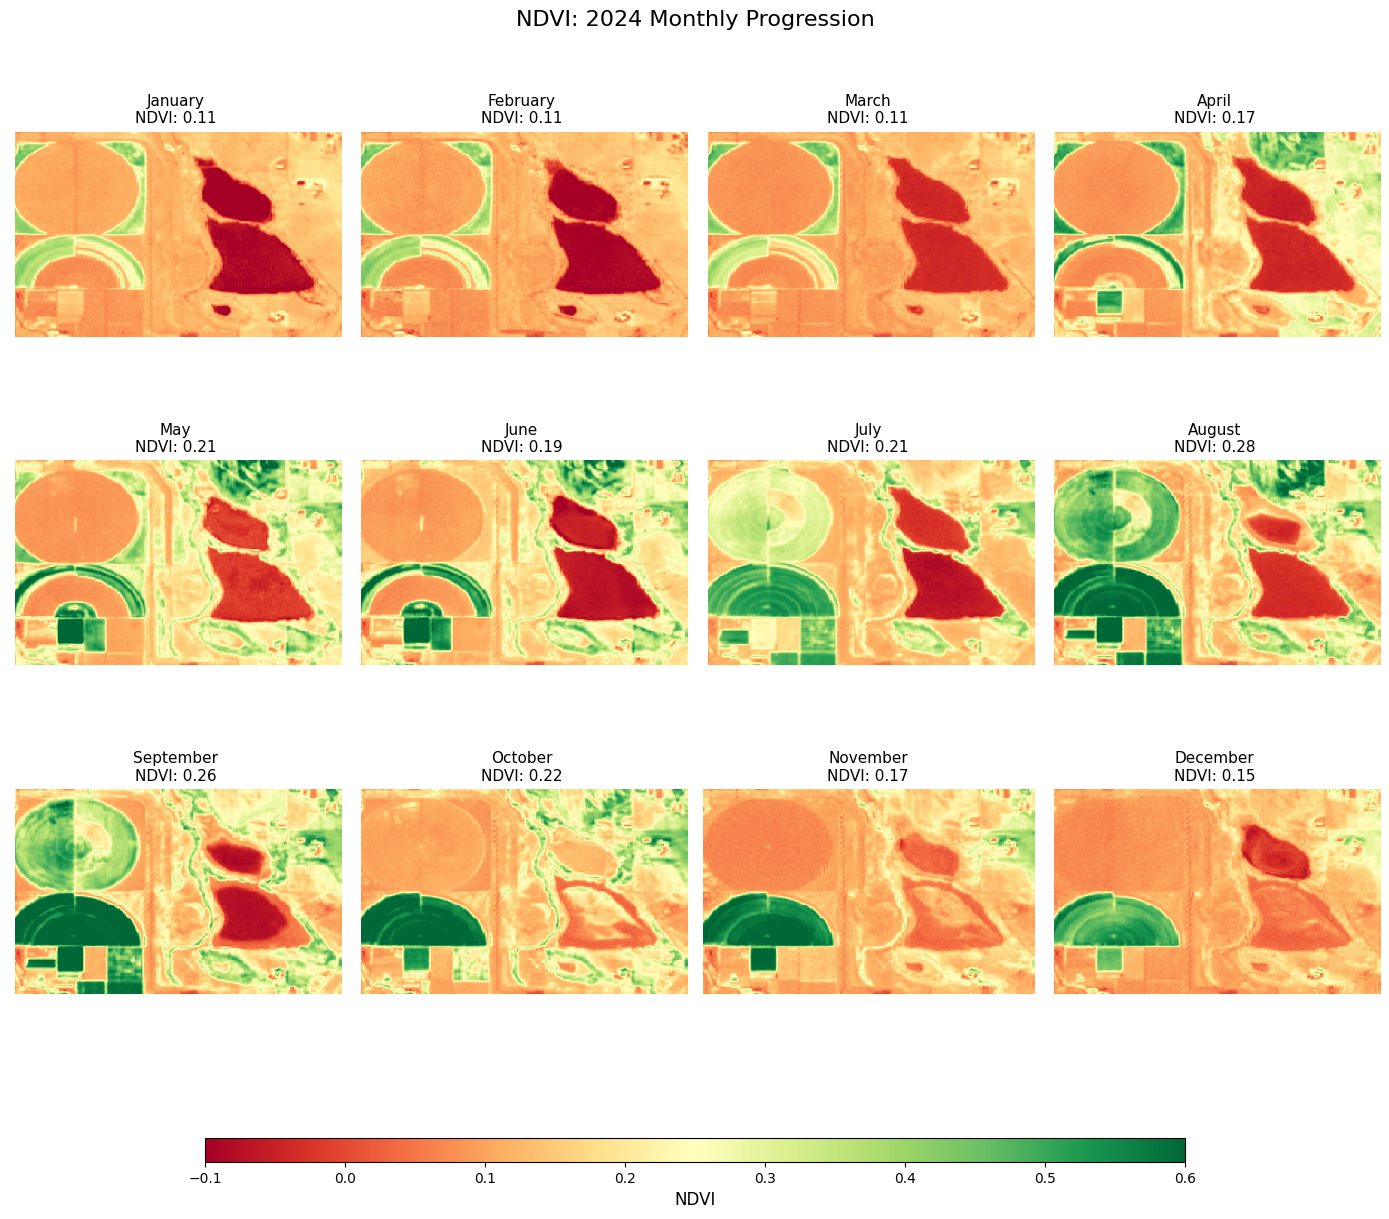

In [11]:
fig, axes = plt.subplots(rows, cols, figsize=(14, 4*rows))
axes = axes.flatten()

vmin, vmax = -0.1, 0.6

for idx, month_info in enumerate(monthly_data):
    im = axes[idx].imshow(month_info['ndvi'], cmap='RdYlGn', vmin=vmin, vmax=vmax)
    axes[idx].set_title(f"{month_info['month_name']}\nNDVI: {month_info['mean_ndvi']:.2f}", fontsize=11)
    axes[idx].axis('off')

# Hide unused subplots
for idx in range(n_months, len(axes)):
    axes[idx].axis('off')

plt.suptitle(f"NDVI: {year} Monthly Progression", fontsize=16)
plt.tight_layout()

# Add horizontal colorbar at the bottom
cbar_ax = fig.add_axes([0.15, 0.02, 0.7, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('NDVI', fontsize=12)
cbar.set_ticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

plt.subplots_adjust(bottom=0.08)
plt.show()

---
## 8. Create Animation

Now let's create an animated visualization that cycles through the months.

In [12]:
# Create figure with two panels: RGB and NDVI side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Initialize with first frame
rgb_im = axes[0].imshow(monthly_data[0]['rgb'])
axes[0].set_title("True Color (RGB)", fontsize=12)
axes[0].axis('off')

ndvi_im = axes[1].imshow(monthly_data[0]['ndvi'], cmap='RdYlGn', vmin=-0.1, vmax=0.6)
axes[1].set_title("NDVI", fontsize=12)
axes[1].axis('off')

# Add colorbar for NDVI
cbar = fig.colorbar(ndvi_im, ax=axes[1], shrink=0.8)
cbar.set_label('NDVI')

# Title that will be updated
title = fig.suptitle(monthly_data[0]['month_name'] + f" {year}", fontsize=16)

plt.tight_layout()

def update(frame):
    """Update function for animation."""
    month_info = monthly_data[frame]
    
    rgb_im.set_array(month_info['rgb'])
    ndvi_im.set_array(month_info['ndvi'])
    title.set_text(f"{month_info['month_name']} {year} — Mean NDVI: {month_info['mean_ndvi']:.2f}")
    
    return [rgb_im, ndvi_im, title]

# Create animation
anim = FuncAnimation(
    fig, 
    update, 
    frames=len(monthly_data),
    interval=800,  # milliseconds per frame
    blit=True,
    repeat=True
)

# Display in notebook
plt.close()  # Prevent static display
HTML(anim.to_jshtml())

---
## 9. Save Animation as GIF

Save the animation as a GIF file you can share or view outside the notebook.

In [13]:
# Recreate the animation for saving
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

rgb_im = axes[0].imshow(monthly_data[0]['rgb'])
axes[0].set_title("True Color (RGB)", fontsize=12)
axes[0].axis('off')

ndvi_im = axes[1].imshow(monthly_data[0]['ndvi'], cmap='RdYlGn', vmin=-0.1, vmax=0.6)
axes[1].set_title("NDVI", fontsize=12)
axes[1].axis('off')

cbar = fig.colorbar(ndvi_im, ax=axes[1], shrink=0.8)
cbar.set_label('NDVI')

title = fig.suptitle(monthly_data[0]['month_name'] + f" {year}", fontsize=16)
plt.tight_layout()

def update(frame):
    month_info = monthly_data[frame]
    rgb_im.set_array(month_info['rgb'])
    ndvi_im.set_array(month_info['ndvi'])
    title.set_text(f"{month_info['month_name']} {year} — Mean NDVI: {month_info['mean_ndvi']:.2f}")
    return [rgb_im, ndvi_im, title]

anim = FuncAnimation(fig, update, frames=len(monthly_data), interval=800, blit=True)

# Save as GIF
output_path = "../outputs/seasonal_animation.gif"
anim.save(output_path, writer='pillow', fps=1.5)
plt.close()

print(f"Animation saved to: {output_path}")

Animation saved to: ../outputs/seasonal_animation.gif


---
## Summary

**What we accomplished:**
1. Loaded satellite imagery for 12 months (one image per month)
2. Computed NDVI for each month
3. Visualized the seasonal trend as a time series graph
4. Created a grid view of all months
5. Built an animated visualization of the seasonal cycle

**Key insights:**
- Vegetation follows a predictable seasonal "pulse"
- NDVI quantifies this pulse better than true color images
- Time series analysis reveals patterns invisible in single snapshots
- Agricultural areas show the most dramatic seasonal change

**Applications of time series analysis:**
- Crop monitoring and yield prediction
- Drought detection (compare to "normal" years)
- Deforestation tracking
- Urban expansion monitoring
- Climate change impact studies

**Next steps:**
- Compare 2024 to a drought year
- Look at a specific crop field's growing season
- Detect anomalies (fire scars, floods, etc.)